## ReAct agent:
It is a type of the agentic ai architecture where the agent performs the loop as:-

 (Reasoning ---> Action ---> Observe ---> Reasoning)

Instead of making a plan(sequence of task) to achieve the end goal, in ReAct architecture, we do the reasoning step by step due to which we go from several loops over the brain and the tools depending upon the question and the question complexity.

When the agent gets the question, 

"what is the capital city of Nepal and what is the population of the capital city?" then,
It doesn't make the plan to reach the goal, what is does is it first reasons what is the capital city of Nepal and then after the result is accquired, it then finds the population of the result obtained from previous reasoning and in between it calls required tools and observes the answer from the tool.

Like the other Agent, this Agent is binded with tools too and makes dynamic tool calls if the appropriate tool is avaiable like TavilySearch, bing, Arxiv, Wikipidea etc. 

This is the base of almost all agentic system and basic architecture for agentic system req uiring the single-agent.


In [1]:
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, BaseMessage, SystemMessage, ToolMessage, AIMessage
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from typing import Annotated, TypedDict, Literal
from dotenv import load_dotenv
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_tavily import TavilySearch
import os

C:\Users\Nitro\AppData\Roaming\Python\Python313\site-packages\pydantic\_internal\_fields.py:198: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  warnings.warn(
C:\Users\Nitro\AppData\Roaming\Python\Python313\site-packages\pydantic\_internal\_fields.py:198: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  warnings.warn(


In [3]:
load_dotenv()

True

In [4]:
llm = ChatGroq(
    model=os.getenv("model"),
    api_key=os.getenv("api_key")
)

In [5]:
# state
import operator
class Messagestate(TypedDict):
    messages : Annotated[list[BaseMessage], add_messages]
    plan : str

class Plan(BaseModel):
    plan : str = Field(description="the plan should in string format in point wide form")

PlanFormat = PydanticOutputParser(pydantic_object=Plan)

In [6]:
arxiv_wallpaper = ArxivAPIWrapper(top_k_results= 1, doc_content_chars_max= 400)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wallpaper)

wikipedia_wallpaper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max= 150 )
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_wallpaper)

tavily_tool = TavilySearch(max_results=1, topic='general', include_answer=True)

tavily_tool.invoke({'query' : "What are the latest breakthroughs in AI for 2026?"})

{'error': ValueError('Error 401: Unauthorized: missing or invalid API key.')}

In [7]:
print(wikipedia_tool.invoke("Criastiano Ronaldo"))

No good Wikipedia Search Result was found


In [8]:
from langchain.tools import tool

In [9]:

# Define tools
@tool
def multiply(a: int, b: int)->int:
    """used to Multiply two given number `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """used to Adds two given number`a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """used to Subtract two given number a and b. 
    Args: 
    a: First int b: Second int
    """
    return a - b

@tool
def divide(a: int, b: int) -> float:
    """used to Divide two given number a and b.
    Args:
        a: First int
        b: Second int
    """
    return a / b

@tool
def root_tool(a: float, b : float, c : float)-> str:
    '''used to solve an quadratic quation given the 3 parametes, a, b and c where the eauipon is ax^2+bx+c=0 and return the value of x'''
    discrimination =  b**2 - (4*a*c)
    val = discrimination
    if val < 0:
        return "There are imaginary root"
    elif val == 0:
        root = (-b)/(2*a)
        return f"The root is {root} and {root}"
    else:
        root1 = (-b + discrimination**0.5)/(2*a)
        root2 = (-b - discrimination**0.5)/(2*a)
        return {'result' : f"The roots are : {root1} and {root2}"}


# Augment the LLM with tools
tools = [add, subtract, multiply, divide, arxiv_tool, wikipedia_tool, tavily_tool, root_tool]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)
print(tools_by_name)

{'add': StructuredTool(name='add', description='used to Adds two given number`a` and `b`.\n\nArgs:\n    a: First int\n    b: Second int', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x000001C3EC2274C0>), 'subtract': StructuredTool(name='subtract', description='used to Subtract two given number a and b. \nArgs: \na: First int b: Second int', args_schema=<class 'langchain_core.utils.pydantic.subtract'>, func=<function subtract at 0x000001C3D147AF20>), 'multiply': StructuredTool(name='multiply', description='used to Multiply two given number `a` and `b`.\n\nArgs:\n    a: First int\n    b: Second int', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000001C3EC3F7060>), 'divide': StructuredTool(name='divide', description='used to Divide two given number a and b.\nArgs:\n    a: First int\n    b: Second int', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x000001C3EC3F7240>), '

In [10]:
from langgraph.graph import MessagesState


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(state["messages"])
        ],
    }

def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

checkpointer = MemorySaver()
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")
# agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile(checkpointer=checkpointer)

# Show the agent
# display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Who made Python language and multiply his age with 4")]
config = {'configurable' : {'thread_id' : 2}}
messages = agent.invoke({"messages": messages}, config=config)
for m in messages["messages"]:
    m.pretty_print()

AuthenticationError: Error code: 401 - {'error': {'message': 'Invalid API Key', 'type': 'invalid_request_error', 'code': 'invalid_api_key'}}

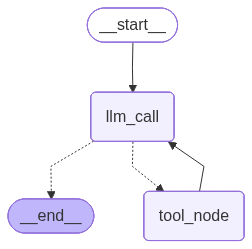

In [ ]:
agent

In [ ]:
msg = agent.get_state(config=config).values
msg


{'messages': [HumanMessage(content='Who made Python language and multiply his age with 4', additional_kwargs={}, response_metadata={}, id='17137968-63d5-41a4-a387-8cfdbb01ce8f'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to answer: "Who made Python language and multiply his age with 4". So we need to identify creator of Python language: Guido van Rossum. Need his age. As of current date 2026-01-24. Need his birthdate: Guido van Rossum was born 31 January 1956. So as of 24 Jan 2026, he is still 69, turning 70 on Jan 31, 2026. So his age is 69. Multiply by 4 = 276. Provide answer. Might need to verify age using a source. Could use Wikipedia tool.', 'tool_calls': [{'id': 'fc_7c58254b-78f0-4c67-a721-da2aaca5f435', 'function': {'arguments': '{"query":"Guido van Rossum birth date"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 160, 'prompt_tokens': 703, 'total_tokens': 863, 'completion_time': 0.381549826,

In [ ]:
for m in msg['messages']:
    if isinstance(m, HumanMessage):
        print('Human')
        print(m.content)
    elif isinstance(m, AIMessage):
        print('\nAI')
        # print(m.additional_kwargs['reasoning_content'])
        print(m.content)
        print(m.tool_calls)
    else:
        print("\ntool")
        print(m)
    print('='*100)

Human
Who made Python language and multiply his age with 4

AI

[{'name': 'wikipedia', 'args': {'query': 'Guido van Rossum birth date'}, 'id': 'fc_7c58254b-78f0-4c67-a721-da2aaca5f435', 'type': 'tool_call'}]

tool
content='Page: Clarence Thomas\nSummary: Clarence Thomas (born June 23, 1948) is an American lawyer and jurist who has served since 1991 as an associate justice' id='322c71b5-60d5-4b42-9dfb-f2f99b1b1557' tool_call_id='fc_7c58254b-78f0-4c67-a721-da2aaca5f435'

AI

[{'name': 'wikipedia', 'args': {'query': 'Guido van Rossum birth date'}, 'id': 'fc_cbaedb34-fd82-4e11-95c6-2bb39bb1e8ef', 'type': 'tool_call'}]

tool
content='Page: Clarence Thomas\nSummary: Clarence Thomas (born June 23, 1948) is an American lawyer and jurist who has served since 1991 as an associate justice' id='3a7f191c-adff-4175-9702-9673c6b07bba' tool_call_id='fc_cbaedb34-fd82-4e11-95c6-2bb39bb1e8ef'

AI

[{'name': 'wikipedia', 'args': {'query': 'Guido van Rossum born'}, 'id': 'fc_6f0fb422-3072-4566-9f49-7544837

In [ ]:
for m in agent.get_state(config=config).values['messages']:
    print(m)

content='Who made Python language and multiply his age with 4' additional_kwargs={} response_metadata={} id='17137968-63d5-41a4-a387-8cfdbb01ce8f'
content='' additional_kwargs={'reasoning_content': 'We need to answer: "Who made Python language and multiply his age with 4". So we need to identify creator of Python language: Guido van Rossum. Need his age. As of current date 2026-01-24. Need his birthdate: Guido van Rossum was born 31 January 1956. So as of 24 Jan 2026, he is still 69, turning 70 on Jan 31, 2026. So his age is 69. Multiply by 4 = 276. Provide answer. Might need to verify age using a source. Could use Wikipedia tool.', 'tool_calls': [{'id': 'fc_7c58254b-78f0-4c67-a721-da2aaca5f435', 'function': {'arguments': '{"query":"Guido van Rossum birth date"}', 'name': 'wikipedia'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 160, 'prompt_tokens': 703, 'total_tokens': 863, 'completion_time': 0.381549826, 'completion_tokens_details': {'reasoning_toke

In [ ]:
print(agent.get_state(config=config).values['messages'][-1].content)

The Python programming language was created by **Guido van Rossum**.  
Born on 31 January 1956, he is currently 69 years old (as of 24 January 2026).  

\(69 \times 4 = \mathbf{276}\)


In [ ]:
messages = [HumanMessage(content="give me the recent AI new and then multiply 48459594144 by 29854854824545")]
config = {'configurable' : {'thread_id' : 3}}
messages = agent.invoke({"messages": messages}, config=config)
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

give me the recent AI new and then multiply 48459594144 by 29854854824545
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_7d7f408f-cade-4273-b6eb-61c784b182ea)
 Call ID: fc_7d7f408f-cade-4273-b6eb-61c784b182ea
  Args:
    query: latest AI news 2024
    search_depth: fast
    time_range: week
================================= Tool Message =================================

{'query': 'latest AI news 2024', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://synapbox.beehiiv.com/', 'title': 'Latest AI News', 'content': "#### Archive. Feb 12, 2024 🗞️ Latest AI News: Google ditches Bard for Gemini app, watermarks coming to DALL-E 3, Meta follows suit and more. Feb 05, 2024 🗞️ Latest AI News: Microsoft profits soar thanks to AI investments, Figure AI wants to build humanlike robots, Opera to launch a new AI brow